In [ ]:
import bs4 as bs
import spacy
import pandas as pd
import string
import random
import numpy as np
import matplotlib.pyplot as plt

from spacy.training.example import Example
from spacy.util import compounding
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
nlp = spacy.load("pt_core_news_sm")

# Carregamento dos dados
dataset = pd.read_csv("Train50.csv", sep=";", encoding= "utf-8")

# Função para preprocessamento do texto
stop_words = STOP_WORDS
points = string.punctuation

def preprocess_text(text):
    text = text.lower()
    doc = nlp(text)
    
    list_tokens = []
    for token in doc:
        list_tokens.append(token.lemma_)
        
    lista_tokens = [token for token in list_tokens if token not in stop_words and token not in points]
    lista_tokens = [" ".join([str(element) for element in lista_tokens if not element.isdigit()])]
    return lista_tokens

# Pré-processamento da base de dados
dataset["tweet_text"] = dataset["tweet_text"].apply(preprocess_text)

In [ ]:
# Tratamento de classe
exemple_database = [["este trabalho é agradavel", {"ALEGRIA": True, "MEDO": False}], ["este lugar continua assustador", {"ALEGRIA": False, "MEDO": True}]]
database_final = []

for text, emotion in zip(dataset["tweet_text"], dataset["sentiment"]):
    if isinstance(text, list):
        text = " ".join(text)
    if emotion == 1:
        dic = {"ALEGRIA": True, "MEDO": False}
    elif emotion == 0:
        dic = {"ALEGRIA": False, "MEDO": True}
    database_final.append([text, dic.copy()])

In [ ]:
# Criação do classificador
model = spacy.blank("pt")
category = model.add_pipe("textcat")
category.add_label("ALEGRIA")
category.add_label("MEDO")
history = []
model.begin_training()

for e in range(30):
    random.shuffle(database_final)
    losses = {}
    batch_sizes = compounding(32.0, 256.0, 1.5)
    
    # Mini-batches de 1000 exemplos
    for batch in spacy.util.minibatch(database_final, size = batch_sizes):
        exemples = []
        
        for text, category in batch:
            doc = model.make_doc(text)
            exemple = Example.from_dict(doc, {"cats": category})
            exemples.append(exemple)
            
        model.update(exemples, losses= losses)
        
    if e % 3 == 0:
        print(f"Epoca {e}: {losses}")
        history.append(losses)

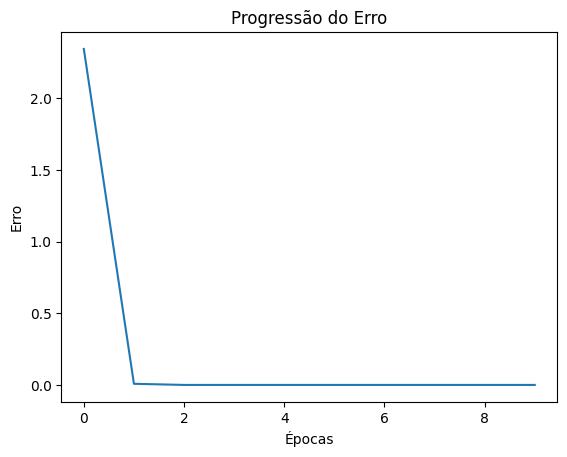

In [64]:
# Plotando a evolução do erro
history_loss = []

for i in history:
    history_loss.append(i.get("textcat"))
    
history_loss = np.array(history_loss)
plt.plot(history_loss)
plt.title("Progressão do Erro")
plt.xlabel("Épocas")
plt.ylabel("Erro")
plt.show()

In [ ]:
# Salvando o modelo treinado
model.to_disk("model_twitter")

In [ ]:
# Carregando o modelo treinado
model = spacy.load("model_twitter")

In [65]:
# Teste com uma frase alegre
text_positive = "Me permito ser feliz, mesmo que só por um instante de cada vez."
token = preprocess_text(text_positive)
text_processed = " ".join(token)
prev = model(text_processed)
prev.cats

{'ALEGRIA': 0.9999998807907104, 'MEDO': 9.024327596307558e-08}

In [ ]:
# AValiaçao do modelo
prevs = []

for texts in dataset["tweet_text"]:
    if isinstance(texts, list):
        texts = " ".join(texts)
    prev = model(texts)
    prevs.append(prev.cats)
    
prevs_final = []

for prev in prevs:
    if prev["ALEGRIA"] > prev["MEDO"]:
        prevs_final.append(1)
    else:
        prevs_final.append(0)

prevs_final = np.array(prevs_final)
response_test = dataset["sentiment"].values

In [ ]:
# Avaliação final do modelo com accuracy
accuracy_score(response_test, prevs_final)

1.0

In [ ]:
# Avaliação final do modelo com matriz de confusão
cm = confusion_matrix(response_test, prevs_final)
cm

array([[25000,     0],
       [    0, 25000]])

In [72]:
# Avaliando na base de teste
database_test = pd.read_csv("Test.csv", sep=";", encoding="utf-8")
database_test["tweet_text"] = database_test["tweet_text"].apply(preprocess_text)

prevs = []

for texts in database_test["tweet_text"]:
    if isinstance(texts, list):
        texts = " ".join(texts)
    prev = model(texts)
    prevs.append(prev.cats)
    
prevs_final = []

for prev in prevs:
    if prev["ALEGRIA"] > prev["MEDO"]:
        prevs_final.append(1)
    else:
        prevs_final.append(0)

prevs_final = np.array(prevs_final)
response_test = database_test["sentiment"].values

In [ ]:
# Avaliação final do modelo com accuracy
accuracy_score(response_test, prevs_final)

0.9986

In [ ]:
# Avaliação final do modelo com matriz de confusão
cm = confusion_matrix(response_test, prevs_final)
cm

array([[2496,    4],
       [   3, 2497]])